<a href="https://colab.research.google.com/github/mandraa/MachineLearning/blob/main/Job_Sheet_10_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama : Agilar Gumilar

Kelas : TI3G

NIM  : 2141720106

**PRAKTIKUM 1**

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup input pipeline

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Awalnya ini mengembalikan dataset (teks, pasangan label)

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b"This is the only full length feature film about the world of bridge. I found the first 10 minutes a bit slow, but after that, the movie is absolutely perfect in describing professional bridge players and how they go about earning a living. <br /><br />Some of the scenes are very funny. I don't think that a non-bridge player would get the charm of this movie. <br /><br />Some of the dresses are really beautiful, pity the movie is in black and white - I can only imagine what they would look like in colour. The way the media are portrayed is absolutely hilarious. There is no way on earth bridge will ever be like that. <br /><br />Watch it as soon as you can, and tell your friends about it."
 b'This, the finest achievement from Georg Wilhelm Pabst\'s Social Realism period is based upon a tragedy in early 1906 that claimed the lives of nearly 1100 French miners as a coal dust explosion deep in mines at Courrieres in northern France took place after a fire had smouldered for three

Buat Teks Encoder

In [6]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [7]:
vocab=np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [8]:
encoded_example=encoder(example)[:3].numpy()
encoded_example

array([[11,  7,  2, ...,  0,  0,  0],
       [11,  2,  1, ...,  0,  0,  0],
       [11,  7, 29, ...,  0,  0,  0]])

In [9]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"This is the only full length feature film about the world of bridge. I found the first 10 minutes a bit slow, but after that, the movie is absolutely perfect in describing professional bridge players and how they go about earning a living. <br /><br />Some of the scenes are very funny. I don't think that a non-bridge player would get the charm of this movie. <br /><br />Some of the dresses are really beautiful, pity the movie is in black and white - I can only imagine what they would look like in colour. The way the media are portrayed is absolutely hilarious. There is no way on earth bridge will ever be like that. <br /><br />Watch it as soon as you can, and tell your friends about it."
Round-trip:  this is the only full [UNK] feature film about the world of [UNK] i found the first 10 minutes a bit slow but after that the movie is absolutely perfect in [UNK] [UNK] [UNK] [UNK] and how they go about [UNK] a living br br some of the scenes are very funny i dont think that a 

Buat Model

In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [12]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 5s 5s/step
[-0.01930406]


In [13]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 84ms/step
[-0.01930406]


In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train Model

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 54s 111ms/step - loss: 0.6255 - accuracy: 0.5825 - val_loss: 0.4574 - val_accuracy: 0.7589
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3855 - accuracy: 0.8239 - val_loss: 0.3614 - val_accuracy: 0.8484
Epoch 3/10
391/391 [==============================] - 26s 65ms/step - loss: 0.3367 - accuracy: 0.8523 - val_loss: 0.3447 - val_accuracy: 0.8385
Epoch 4/10
391/391 [==============================] - 25s 64ms/step - loss: 0.3207 - accuracy: 0.8624 - val_loss: 0.3363 - val_accuracy: 0.8380
Epoch 5/10
391/391 [==============================] - 24s 62ms/step - loss: 0.3136 - accuracy: 0.8641 - val_loss: 0.3447 - val_accuracy: 0.8266
Epoch 6/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3098 - accuracy: 0.8667 - val_loss: 0.3233 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 25s 63ms/step - loss: 0.3066 - accuracy: 0.8679 - val_loss: 0.3253 - val_accuracy

In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 30ms/step - loss: 0.3168 - accuracy: 0.8616
Test Loss: 0.31680282950401306
Test Accuracy: 0.8616399765014648


(0.0, 0.6417414829134941)

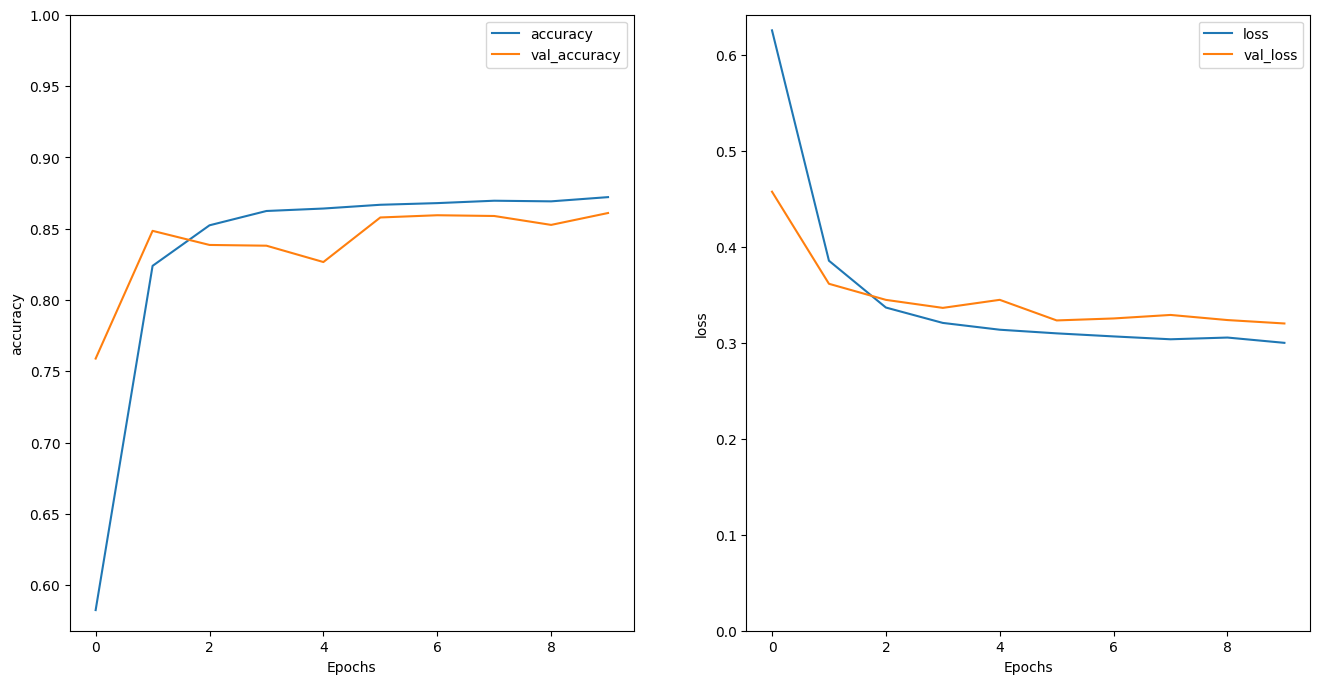

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [18]:
sample_text = ('The movie was cool. The animation and the graphics '
                'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 2s 2s/step


Stack two or more LSTM layers

In [19]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 76s 150ms/step - loss: 0.6127 - accuracy: 0.6083 - val_loss: 0.4217 - val_accuracy: 0.8167
Epoch 2/10
391/391 [==============================] - 48s 123ms/step - loss: 0.3829 - accuracy: 0.8345 - val_loss: 0.3487 - val_accuracy: 0.8458
Epoch 3/10
391/391 [==============================] - 46s 117ms/step - loss: 0.3435 - accuracy: 0.8553 - val_loss: 0.3380 - val_accuracy: 0.8568
Epoch 4/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3241 - accuracy: 0.8621 - val_loss: 0.3277 - val_accuracy: 0.8479
Epoch 5/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3162 - accuracy: 0.8668 - val_loss: 0.3224 - val_accuracy: 0.8536
Epoch 6/10
391/391 [==============================] - 46s 118ms/step - loss: 0.3085 - accuracy: 0.8693 - val_loss: 0.3224 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 45s 115ms/step - loss: 0.3067 - accuracy: 0.8697 - val_loss: 0.3165 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 19s 49ms/step - loss: 0.3150 - accuracy: 0.8508
Test Loss: 0.31498461961746216
Test Accuracy: 0.8507999777793884


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0695598]]


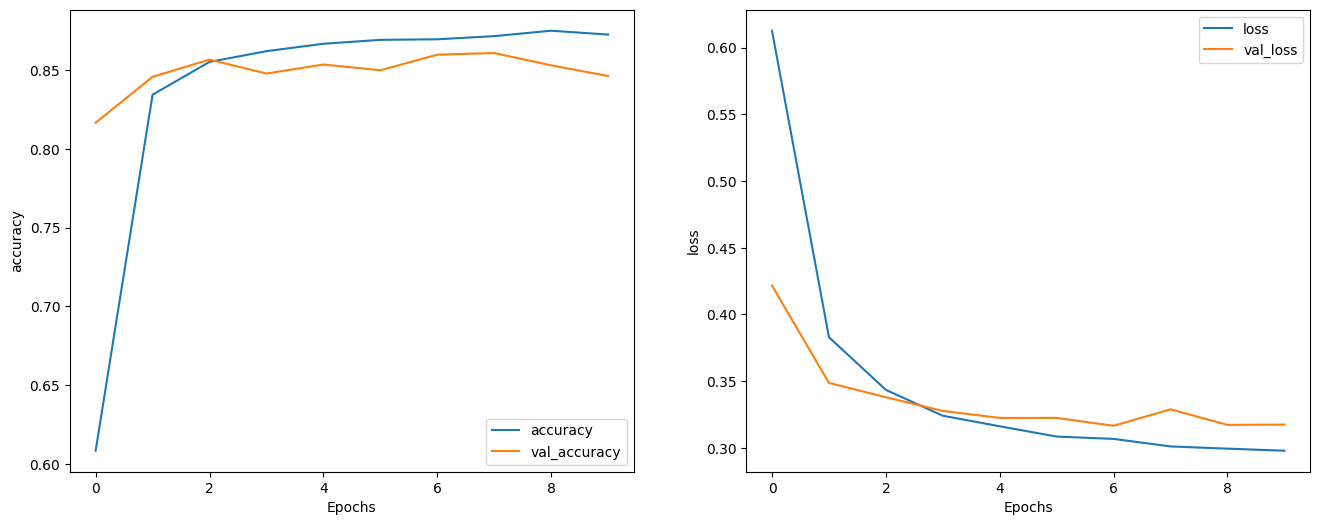

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

**PRAKTIKUM 2**

In [25]:
#Import TensorFlow

import tensorflow as tf
import numpy as np
import os
import time

In [26]:
#Download Dataset Shakespeare

path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


In [27]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [28]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [29]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


Olah Teks

In [30]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [31]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None)

In [32]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [33]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [34]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [35]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [36]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

In [37]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [38]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [39]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [40]:
seq_length = 100

In [41]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [42]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [43]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [44]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [45]:
dataset = sequences.map(split_input_target)

In [46]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [47]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

Buat Model

In [48]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [49]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [50]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

Uji Model

In [51]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [52]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_4 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [53]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [54]:
sampled_indices

array([27, 62, 58, 21, 29, 64,  7, 43, 14, 34, 15, 48, 40, 24, 44, 13,  9,
       40, 41, 53, 51,  1, 11, 36, 62, 52, 53, 39, 22,  1, 37, 39, 21, 55,
        8,  9, 35, 44, 23, 16, 58, 21,  3, 43, 20, 23, 26,  9, 47,  8, 21,
       11, 44, 39, 21, 20, 31, 32, 56, 29, 60, 60,  4, 24, 32,  6, 52, 34,
        7, 42, 25, 32, 46, 22, 63,  3, 58, 60, 26, 47, 56,  1, 23,  4, 22,
       17, 18, 12, 41, 63, 36, 19, 52, 35, 47, 38, 53, 45, 19, 21])

In [55]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ion of his frailty, many\ndeceiving promises of life; which I by my good\nleisure have discredited to '

Next Char Predictions:
 b"NwsHPy,dAUBiaKe?.abnl\n:WwmnZI\nXZHp-.VeJCsH!dGJM.h-H:eZHGRSqPuu$KS'mU,cLSgIx!suMhq\nJ$IDE;bxWFmVhYnfFH"


Train Model

In [56]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [57]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1895423, shape=(), dtype=float32)


In [58]:
tf.exp(example_batch_mean_loss).numpy()

65.992584

In [59]:
model.compile(optimizer='adam', loss=loss)

In [60]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [61]:
EPOCHS=20

In [62]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 14s 59ms/step - loss: 2.7317
Epoch 2/20
172/172 [==============================] - 11s 56ms/step - loss: 1.9941
Epoch 3/20
172/172 [==============================] - 11s 56ms/step - loss: 1.7206
Epoch 4/20
172/172 [==============================] - 12s 57ms/step - loss: 1.5607
Epoch 5/20
172/172 [==============================] - 12s 56ms/step - loss: 1.4605
Epoch 6/20
172/172 [==============================] - 12s 56ms/step - loss: 1.3907
Epoch 7/20
172/172 [==============================] - 12s 55ms/step - loss: 1.3388
Epoch 8/20
172/172 [==============================] - 12s 55ms/step - loss: 1.2920
Epoch 9/20
172/172 [==============================] - 12s 56ms/step - loss: 1.2516
Epoch 10/20
172/172 [==============================] - 11s 56ms/step - loss: 1.2111
Epoch 11/20
172/172 [==============================] - 11s 56ms/step - loss: 1.1711
Epoch 12/20
172/172 [==============================] - 11s 56ms/step - loss: 1.1300
E

In [63]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [64]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [65]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Nay, then 'tis just.

LUCIO:
Jod's valiant Friar John Dorset!

HERMIONE:
Sir, brave Mercutio's peits,
'tis time even that with kind comforts.

SICINIUS:
Where's a best!

COMINIUS:
Though that thy king comes well, bold for the mind;
For wheels, her life, still'd my profit
With pains and me-ishes, weigh Oxford.'

KING RICHARD II:
Well she longed had before thine fine;
For what is this of Bolingbroke'?

ALONSO:
Prithee, work you on:
Take my ancient quarters, fairly strongure!

KATHARINA:
Here in this coil
Savine that. But why commands the crown that are upon the ground.

DUKE OF YORK:
To me thy night: call'd them: when I have mercued
Would harn them to her tears, and show our foes
about your brothers, for the holl houses of uncounsel's reason
But draw our country to deck on.

CAMILLO:
Yes, all displees. Good, thou winter
To your youthful so? Thus with his mother will not pass. This action I for my count,
I was your follight modesting tongue.

MARCIUS:
Is me your lordship to weal pi

In [66]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nAt little point contradicts!\n\nSecond Keeper:\nFor comfort have I last in vainted bring.\nThis is a haper footing day nor lack?\nand and the thought once possess'd with God\nEsseved themselves, for you to me;\nAnd witch so my bosom, if orce no less than mine;\nMy bosom and unpentions and goods,\nWhich I sea-cle quter's mischance.\n\nMERCUTIO:\nO, he that looks it now so much be he tender.\n\nHENRY BOLINGBROKE:\nGood madam,--by weapon, no remorse!\n\nCLEOMENES:\nWhile I suppose to my service?\n\nBIONDELLO:\nI would have dainted spirit, we must taxe it out, a very little therefore,\nYou know the cares, for comes what a strange\nHast thou purposen' the other talks\nWorthy found. Come, I'll bride whither myself and my best.\n\nGREMIO:\nI know, thou wilt object my studious liege;\nAnd that to do so soundly in the bissop holy where\nThey are but diseased o'erpaptable.\n\nShepherd:\nBeseech your honour, I have cross you.\n\nDUKE VINCENTIO:\nTHou darest vengurably accusa

In [67]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [68]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO: Nay, mother;
A man that cive my oath awake in him
And plucked both thee for this enemies.
No smile 


**TUGAS**

In [69]:
class CustomTraining(MyModel):
  @tf.function
  def train_step(self, inputs):
    inputs, labels = inputs
    with tf.GradientTape() as tape:
      predictions = self(inputs, training=True)
      loss = self.loss(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return {'loss': loss}

In [70]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [71]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [72]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 14s 57ms/step - loss: 2.6902


In [73]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
        logs = model.train_step([inp, target])
        mean.update_state(logs['loss'])

        if batch_n % 50 == 0:
            template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
            print(template)

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 2.1758
Epoch 1 Batch 50 Loss 2.0039
Epoch 1 Batch 100 Loss 1.9878
Epoch 1 Batch 150 Loss 1.8624

Epoch 1 Loss: 1.9744
Time taken for 1 epoch 12.43 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.8433
Epoch 2 Batch 50 Loss 1.7292
Epoch 2 Batch 100 Loss 1.6596
Epoch 2 Batch 150 Loss 1.6433

Epoch 2 Loss: 1.6968
Time taken for 1 epoch 11.03 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.5978
Epoch 3 Batch 50 Loss 1.5350
Epoch 3 Batch 100 Loss 1.5055
Epoch 3 Batch 150 Loss 1.5427

Epoch 3 Loss: 1.5396
Time taken for 1 epoch 10.94 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.4496
Epoch 4 Batch 50 Loss 1.4540
Epoch 4 Batch 100 Loss 1.4747
Epoch 4 Batch 150 Loss 1.4951

Epoch 4 Loss: 1.4446
Time taken for 1 epoch 20.47 sec
_____________________________________________________________________

**Perbedaan**

Perbedaan utama antara tugas dan praktikum 2 terletak pada train yang digunakan. Praktikum 2 menggunakan train yang lebih umum dan sederhana dengan model.fit, sedangkan kode tuga menggunakan train yang khusus dan kompleks. Dalam pendekatan ini, ada penggunaan metode train_step dalam model turunan yang mengatur train pada tingkat batch. Ini melibatkan perhitungan loss, perhitungan gradien, peningkatan bobot model, dan pemanfaatan tf.metrics.Mean untuk menghitung rata-rata loss selama proses train. Dengan pendekatan ini, terdapat tingkat kontrol yang lebih besar dan fleksibilitas dalam mengatur proses train model.